<a href="https://colab.research.google.com/github/daras-cu/gymnasium-3202/blob/main/DQN_Lunar_Lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium
!pip install matplotlib
!pip install IPython
!pip install swig
!pip install gymnasium[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached swig-4.1.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.7 MB)
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2812243 sha256=b303c802a5aeb3fc7c790dc47cde7664bd99fb5119fe4a31bfcf2ed025a442a0
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf

Code adapted from:
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
https://github.com/yuchen071/DQN-for-LunarLander-v2/blob/main/LunarLander.ipynb

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import random
import math
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [58]:
# Named tuple to store info about transition after action is performed in state
Transition = namedtuple('Transition', ('state', 'action', 'next', 'reward'))

# Class to store memory of recent transitions to sample from for training
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
        

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [68]:
# Class for policy network
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
      super(DQN, self).__init__()

      self.layer1 = nn.Linear(n_observations, 64)
      self.layer2 = nn.Linear(64, 64)
      self.layer3 = nn.Linear(64, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [61]:
# Class for DQN Agent
class QAgent():
  # Initialize with parameters:
  # n_obs, n_actions are number of possible state observations and actions
  # batch_size is the number of transitions sampled from memory buffer
  # gamme is the discount factor
  # mem_size is the size of the memory buffer
  # learn_step is the frequency the target network is updated
  def __init__(self, n_obs, n_actions, batch_size=128, lr=1e-4, gamma=0.99, mem_size=10000, learn_step=5, tau=1e-3):
    self.n_obs = n_obs
    self.n_actions = n_actions
    self.batch_size = batch_size
    self.gamma = gamma
    self.learn_step = learn_step
    self.tau = tau

    # Policy net is a DQN class object to store policy
    # Target net is a copy of policy net which is periodically updated, used for training
    self.policy_net = DQN(n_obs, n_actions).to(device)
    self.target_net = DQN(n_obs, n_actions).to(device)

    # Optimizer and criterion (SmoothL1Loss or MSELoss)
    self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
    self.criterion = nn.SmoothL1Loss()

    self.memory = ReplayMemory(mem_size)
    self.episode_rewards = []
    self.counter = 0

  def select_action(self, state, epsilon):
      
      sample = random.random()
      if sample > epsilon:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return self.policy_net(state).max(1)[1].view(1, 1)
      else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

  def memory_add(self, state, action, next_state, reward):
    self.memory.push(state, action, next_state, reward)

    # Increment counter to run optimize model function every learn_step cycles
    self.counter += 1
    if self.counter % self.learn_step == 0:
      if len(self.memory) >= self.batch_size:
          self.optimize_model()

  def plot_rewards(self, show_result=False):
      plt.figure(1)
      rewards_t = torch.tensor(self.episode_rewards, dtype=torch.float)
      if show_result:
          plt.title('Result')
      else:
          plt.clf()
          plt.title('Training...')
      plt.xlabel('Episode')
      plt.ylabel('Reward')
      plt.plot(rewards_t.numpy())
      # Take 100 episode averages and plot them too
      if len(rewards_t) >= 100:
          means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
          means = torch.cat((torch.zeros(99), means))
          plt.plot(means.numpy())

      plt.pause(0.001)  # pause a bit so that plots are updated
      if is_ipython:
          if not show_result:
              display.display(plt.gcf())
              display.clear_output(wait=True)
          else:
              display.display(plt.gcf())

  def optimize_model(self):
    # Check if there are enough transitions in memory to run a batch
    if len(self.memory) < self.batch_size:
        return
    transitions = self.memory.sample(self.batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # Final states' Q-values do not need to be estimated as they are equal to reward
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - 
    # Apply the policynet to state_batch then select the column of actions taken (index 1)
    # state_action_values is a tensor containing the Q value estimate for each transition in the batch
    state_action_values = self.policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(self.batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * self.gamma) + reward_batch

    # Compute Huber loss - unsqueeze used to match tensor dimensions
    loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
    self.optimizer.step()

    # Perform soft update
    self.softUpdate()

  def softUpdate(self):
    # Soft update of the target network's weights
    # θ′ ← τ θ + (1 −τ )θ′
    target_net_state_dict = self.target_net.state_dict()
    policy_net_state_dict = self.policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
    self.target_net.load_state_dict(target_net_state_dict)

  

In [62]:
def train(env, agent, num_episodes=1000, eps_start=0.9, eps_end=0.05, eps_decay=0.99, target=200):

  epsilon = eps_start

  for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    ep_reward = 0
    for t in count():
      action = agent.select_action(state, epsilon)
      observation, reward, terminated, truncated, _ = env.step(action.item())
      ep_reward += reward
      reward = torch.tensor([reward], device=device)
      done = terminated or truncated

      if terminated:
        next_state = None
      else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

      agent.memory_add(state, action, next_state, reward)
      # Move to the next state
      state = next_state

      if done:
        agent.episode_rewards.append(ep_reward)
        agent.plot_rewards()
        break

      

      epsilon = max(eps_end, epsilon*eps_decay)

  print('Complete')
  agent.plot_rewards(show_result=True)
  plt.ioff()
  plt.show()

Complete


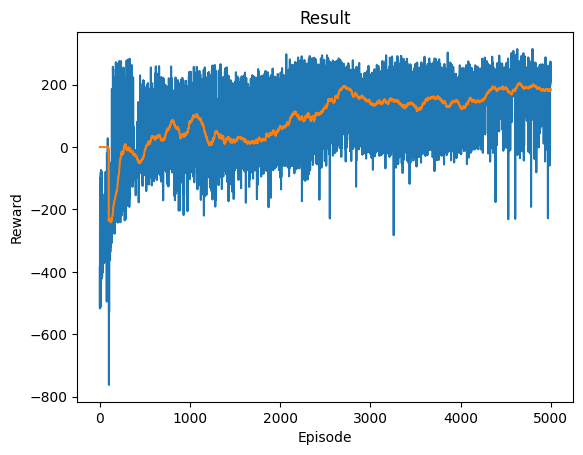

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [70]:
env = gym.make('LunarLander-v2')
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]
agent = QAgent(n_actions=n_actions, n_obs=n_observations, batch_size=64, gamma=0.99)
train(env, agent, num_episodes=5000)

if str(device) == "cuda":
    torch.cuda.empty_cache()

In [72]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title("%s | Step: %d %s" % (env.spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

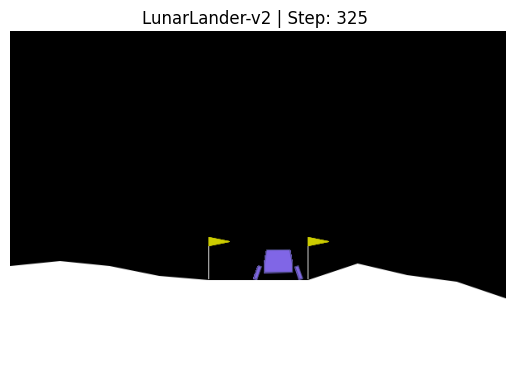

Episode done in 325 steps, total reward 228.02


In [81]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

total_reward = 0.0
total_steps = 0
obs, _ = env.reset()

while True:
    action = agent.select_action(torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0), epsilon=0)
    print(action)
    obs, reward, done, _, _ = env.step(action.item())
    total_reward += reward
    total_steps += 1
    show_state(env,total_steps)
    if done:
        break

print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))
env.close()
env.env.close()

In [86]:
import os
import imageio
from PIL import Image, ImageDraw, ImageFont

def TextOnImg(img, score):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    draw.text((20, 20), f"Score={score: .2f}", fill=(255, 255, 255))

    return np.array(img)

def save_frames_as_gif(frames, filename, path="gifs/"):
    if not os.path.exists(path):
        os.makedirs(path)
        
    print("Saving gif...", end="")
    imageio.mimsave(path + filename + ".gif", frames, fps=60)

    print("Done!")

def gym2gif(env, agent, filename="gym_animation", loop=3):
    frames = []
    for i in range(loop):
        obs, _ = env.reset()
        score = 0
        for idx_step in range(500):
            frame = env.render()
            frames.append(TextOnImg(frame, score))
            action = agent.select_action(torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0), epsilon=0)
            obs, reward, done, _, _ = env.step(action.item())
            score += reward
            if done:
                break
    env.close()
    save_frames_as_gif(frames, filename=filename)

gym2gif(env, agent, loop=5)

Saving gif...Done!
